<a href="https://colab.research.google.com/github/neelkanthrawat/mlph2023-Exercises/blob/main/sheet08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sheet 8

In [1]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

## 1) Anomaly detection for Autoencoders

In [2]:
!pip install wget

In [3]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

 toptagging-short/  'toptagging-short (1).zip'  'toptagging-short (2).zip'   toptagging-short.zip


In [4]:
# Set random seed for PyTorch
seed = 42
torch.manual_seed(seed)

# Set random seed for NumPy
np.random.seed(seed)

In [5]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [6]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around,
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])

        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else:
        x_rot, y_rot = x, y

    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1

    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):

    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]

    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)

    print( "Calculating eta" )
    etas  = eta(pT,pzs)

    print( "Calculating phi" )
    phis  = phi(pxs,pys)

    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)

    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi

    print( "Using pT as weight" )
    weights = pT

    print( "Preprocessing" )

    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )

    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)

    #return z_ori

    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum

    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)

    return z_out

In [7]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


### Getting familiar with the data!

In [8]:
print(z_train.shape)

(30000, 1, 40, 40)


In [9]:
sig = z_train[ np.where(y_train==1) ]
bkg = z_train[ np.where(y_train==0) ]

In [10]:
print(sig.shape); print(bkg.shape)

(15040, 1, 40, 40)
(14960, 1, 40, 40)


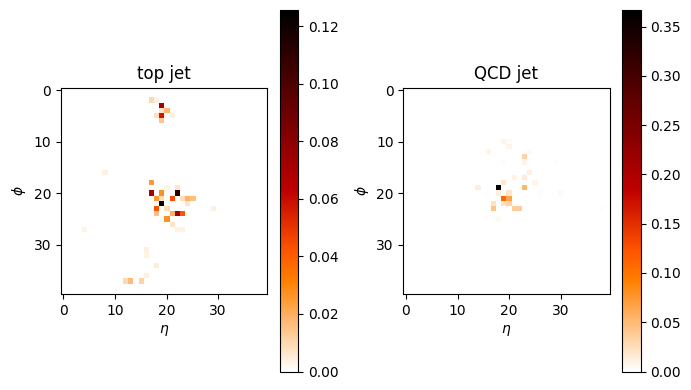

In [11]:
### plotting signal and background (signal is top jet and background is QCD jet)

fig, axs = plt.subplots( 1, 2, figsize=(7,4) )

# plotting one such data
img_sig= axs[0].imshow( sig[2,0,...], cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("top jet")
cbar_sig = fig.colorbar(img_sig, ax=axs[0])

img_bkg=axs[1].imshow( bkg[2,0,...], cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("QCD jet")
cbar_bkg = fig.colorbar(img_bkg, ax=axs[1])

fig.tight_layout()

fig.show()

vmin is: 0.0 and vmax is: 0.1255778604535928


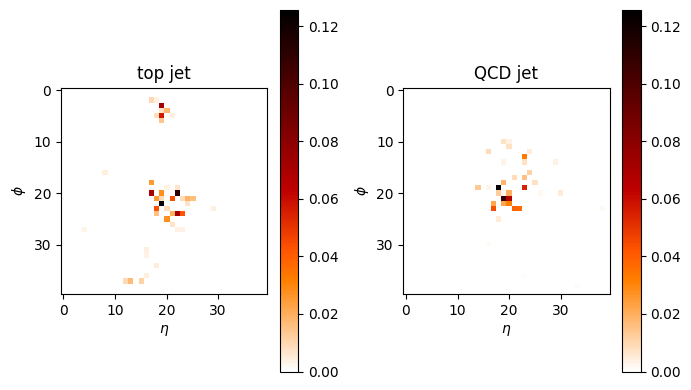

In [12]:
### plotting signal and background (signal is top jet and background is QCD jet)
### now we will normalise the pixel values to a common range!
fig, axs = plt.subplots( 1, 2, figsize=(7,4) )

### Normalise pixel values to a common range
vmin= min(np.min(sig[2,0,...]), np.min(bkg[2,0,...]))
vmax= min(np.max(sig[2,0,...]), np.max(bkg[2,0,...]))
print(f"vmin is: {vmin} and vmax is: {vmax}")

# plotting one such data
img_sig= axs[0].imshow( sig[2,0,...], cmap="gist_heat_r", vmin=vmin, vmax=vmax)
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("top jet")
cbar_sig = fig.colorbar(img_sig, ax=axs[0])

img_bkg=axs[1].imshow( bkg[2,0,...], cmap="gist_heat_r", vmin=vmin, vmax=vmax)
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("QCD jet")
cbar_bkg = fig.colorbar(img_bkg, ax=axs[1])

fig.tight_layout()

fig.show()

vmin is: 0.0 and vmax is: 0.010763395794530907


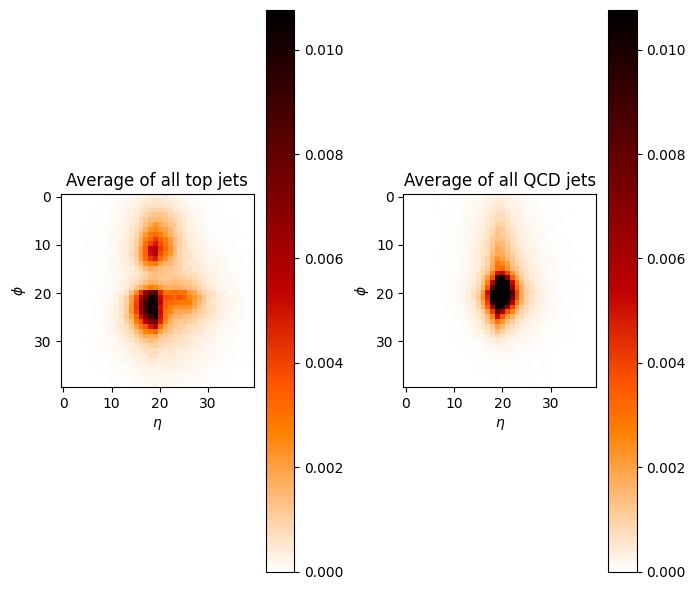

In [13]:
### plotting average signal and background (signal is top jet and background is QCD jet)


fig, axs = plt.subplots( 1, 2, figsize=(7,6) )

### Normalise pixel values to a common range
vmin= min(np.min(sig.mean(0)[0,...]), np.min(bkg.mean(0)[0,...]))
vmax= min(np.max(sig.mean(0)[0,...]), np.max(bkg.mean(0)[0,...]))
print(f"vmin is: {vmin} and vmax is: {vmax}")

img_sig =axs[0].imshow( sig.mean(0)[0,...], cmap="gist_heat_r", vmin=vmin, vmax=vmax )
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("Average of all top jets")
cbar_sig = fig.colorbar(img_sig, ax=axs[0])

img_bkg = axs[1].imshow( bkg.mean(0)[0,...], cmap="gist_heat_r", vmin=vmin, vmax=vmax )
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("Average of all QCD jets")
cbar_bkg = fig.colorbar(img_bkg, ax=axs[1])

fig.tight_layout()

fig.show()

### the following code is not imp

In [14]:
'''
# import numpy as np

# # Create a 4D array with shape (4, 1, 2, 2)
# signal = np.array([
#   [
#     [
#       [1, 2],
#       [3, 4]
#     ]
#   ],

#   [
#     [
#       [5, 6],
#       [7, 8]
#     ]
#   ],

#   [
#     [
#       [9, 10],
#       [11, 12]
#     ]
#   ],

#   [
#     [
#       [13, 14],
#       [15, 16]
#     ]
#   ]
# ])

# # Calculate the mean along the first axis (axis with index 0)
# mean_along_first_axis = signal.mean(0)

# # Select the first element along the first axis and all elements along the remaining axes
# result = mean_along_first_axis[0, ...]

# print("Original array:")
# print(signal)
# print("\nMean along the first axis:")
# print(mean_along_first_axis)
# print("\nResult after indexing:")
# print(result)
# print("shape of the result is:",result.shape)
'''

'\n# import numpy as np\n\n# # Create a 4D array with shape (4, 1, 2, 2)\n# signal = np.array([\n#   [\n#     [\n#       [1, 2],\n#       [3, 4]\n#     ]\n#   ],\n\n#   [\n#     [\n#       [5, 6],\n#       [7, 8]\n#     ]\n#   ],\n\n#   [\n#     [\n#       [9, 10],\n#       [11, 12]\n#     ]\n#   ],\n\n#   [\n#     [\n#       [13, 14],\n#       [15, 16]\n#     ]\n#   ]\n# ])\n\n# # Calculate the mean along the first axis (axis with index 0)\n# mean_along_first_axis = signal.mean(0)\n\n# # Select the first element along the first axis and all elements along the remaining axes\n# result = mean_along_first_axis[0, ...]\n\n# print("Original array:")\n# print(signal)\n# print("\nMean along the first axis:")\n# print(mean_along_first_axis)\n# print("\nResult after indexing:")\n# print(result)\n# print("shape of the result is:",result.shape)\n'

### following cells are important

### Creating the dataloaders

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [16]:
class data_for_tagging(torch.utils.data.Dataset):
  def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
      return self.imgs[idx], self.labels[idx]

In [17]:
tops_train = z_train[ np.where(y_train==1) ]
qcd_train = z_train[ np.where(y_train==0) ]

tops_val = z_val[ np.where(y_val==1) ]
qcd_val = z_val[ np.where(y_val==0) ]

tops_test = z_test[ np.where(y_test==1) ]
qcd_test = z_test[ np.where(y_test==0) ]

print(type(tops_val))# numpy.ndarray

## Converting them to torch.tensor
tops_train_torch=torch.Tensor(tops_train)

<class 'numpy.ndarray'>


In [18]:
z_train.shape, tops_train.shape, qcd_train.shape

((30000, 1, 40, 40), (15040, 1, 40, 40), (14960, 1, 40, 40))

In [19]:
np.shape(np.where(y_train==1))

(1, 15040)

In [20]:
z_train_torch = torch.Tensor(z_train).float()
z_test_torch = torch.Tensor(z_test).float()
z_val_torch = torch.Tensor(z_val).float()

y_train_torch = torch.Tensor(y_train).unsqueeze(-1)
y_test_torch = torch.Tensor(y_test).unsqueeze(-1)
y_val_torch = torch.Tensor(y_val).unsqueeze(-1)

train_dataset = data_for_tagging(z_train_torch, y_train_torch.float())
test_dataset = data_for_tagging(z_test_torch, y_test_torch.float())
val_dataset = data_for_tagging(z_val_torch, y_val_torch.float())

batch_size=64
trn_dataloader = torch.utils.data.DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = torch.utils.data.DataLoader( test_dataset, batch_size=batch_size, shuffle=False )
val_dataloader = torch.utils.data.DataLoader( val_dataset, batch_size=batch_size, shuffle=False )



In [21]:
train_dataset.labels

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

### Creating seperate dataloaders for qcd jets and top jets

Note: For this exercise sheet, we need to first seperate the QCD data and Top data (can be done easily) and then we need to create seperate dataloaders for them!

In [22]:
from torch.utils.data import Subset, DataLoader

# Get indices where ylabel is 0 (for qcd jets)
qcd_indices_train = np.where(y_train == 0)[0]
qcd_indices_val = np.where(y_val == 0)[0]
qcd_indices_test = np.where(y_test == 0)[0]

# Get indices where ylabel is 1 (for top jets)
top_indices_train = np.where(y_train == 1)[0]
top_indices_val = np.where(y_val == 1)[0]
top_indices_test = np.where(y_test == 1)[0]

# Create Subset datasets for qcd and top jets
qcd_dataset_train = Subset(train_dataset, qcd_indices_train)
qcd_dataset_val = Subset(val_dataset, qcd_indices_val)
qcd_dataset_test = Subset(test_dataset, qcd_indices_test)

top_dataset_train = Subset(train_dataset, top_indices_train)
top_dataset_val = Subset(val_dataset, top_indices_val)
top_dataset_test = Subset(test_dataset, top_indices_test)

# Create separate dataloaders for qcd and top jets
qcd_dataloader_train = DataLoader(qcd_dataset_train, batch_size=batch_size, shuffle=True)
qcd_dataloader_val = DataLoader(qcd_dataset_val, batch_size=batch_size, shuffle=True)
qcd_dataloader_test = DataLoader(qcd_dataset_test, batch_size=batch_size, shuffle=False)

top_dataloader_train = DataLoader(top_dataset_train, batch_size=batch_size, shuffle=True)
top_dataloader_val = DataLoader(top_dataset_val, batch_size=batch_size, shuffle=True)
top_dataloader_test = DataLoader(top_dataset_test, batch_size=batch_size, shuffle=False)

In [23]:
len(qcd_dataset_train), qcd_dataset_train.indices

(14960, array([    0,     1,     2, ..., 29987, 29988, 29989]))

In [24]:
len(top_dataset_train), top_dataset_train.indices

(15040, array([   40,    41,    42, ..., 29997, 29998, 29999]))

(a)

In [25]:
# TODO: Construct autoencoder with MLPs
import torch.nn as nn

class AutoencoderMLP(nn.Module):
    def __init__(self, input_size, bottleneck_size, dropout_rate=0.2):
        super(AutoencoderMLP, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout for regularization
            nn.Linear(128, bottleneck_size),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout for regularization
            nn.Linear(128, input_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


(b)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate(model, train_dataloader, val_dataloader,
                       num_epochs=10, learning_rate=0.001,
                       device="cpu", print_epoch=5):

    # Moving the model to the specified device
    model.to(device)

    # Defining our loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Setting the model in training mode
        model.train()

        running_train_loss = 0.0

        # Training the model on the training data
        for data in train_dataloader:
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1).float()
            inputs = inputs.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Computing the loss
            loss = criterion(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Average train loss for the epoch
        average_train_loss = running_train_loss / len(train_dataloader)

        # Set the model in evaluation mode
        model.eval()

        running_val_loss = 0.0

        # Evaluating the model on the validation data
        with torch.no_grad():
            for data in val_dataloader:
                inputs, _ = data
                inputs = inputs.view(inputs.size(0), -1).float()
                inputs = inputs.to(device)

                # Forward pass
                outputs = model(inputs)

                # Computing the loss
                loss = criterion(outputs, inputs)

                running_val_loss += loss.item()

        # Average validation loss for the epoch
        average_val_loss = running_val_loss / len(val_dataloader)

        # Save the losses for plotting or analysis
        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)

        # printing loss after every 'print_epoch' epochs
        if (epoch + 1) % print_epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss}, Val Loss: {average_val_loss}")

    return train_losses, val_losses

In [27]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):

  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")

  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")

  if want_logscale:
    plt.yscale('log')
  plt.legend()

In [28]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20

input_size=40*40
bottleneck_size=20
dropout_rate=0.1
autoencoder = AutoencoderMLP(input_size, bottleneck_size, dropout_rate)
autoencoder.to(device)
train_losses, val_losses = train_and_validate(autoencoder, qcd_dataloader_train, qcd_dataloader_val,
                                            num_epochs=20, learning_rate=5e-4, device=device, print_epoch=2)


Epoch [2/20], Train Loss: 0.00013181419471481768, Val Loss: 0.00011722924862833759
Epoch [4/20], Train Loss: 0.00011142469100797406, Val Loss: 0.0001004285439725273
Epoch [6/20], Train Loss: 9.062532520839052e-05, Val Loss: 8.084377903255338e-05
Epoch [8/20], Train Loss: 7.684946540704805e-05, Val Loss: 6.872342961705887e-05
Epoch [10/20], Train Loss: 6.650656788947228e-05, Val Loss: 5.993424448021378e-05
Epoch [12/20], Train Loss: 5.934601812573691e-05, Val Loss: 5.3042558711964793e-05
Epoch [14/20], Train Loss: 5.345123290914135e-05, Val Loss: 4.688939080286186e-05
Epoch [16/20], Train Loss: 4.869587555886883e-05, Val Loss: 4.239044223285684e-05
Epoch [18/20], Train Loss: 4.588481166666676e-05, Val Loss: 3.950054601411257e-05
Epoch [20/20], Train Loss: 4.362641163588239e-05, Val Loss: 3.743473937910357e-05


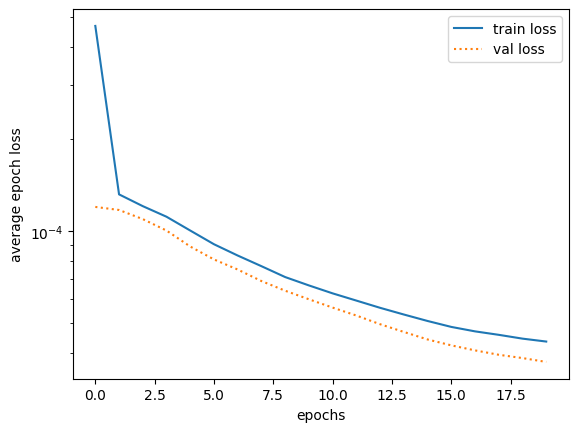

In [29]:
plot_train_and_val_loss(train_losses, val_losses)
plt.show()

### Let's visualise some pixel plots to gain some insight

In [86]:
### defining a function which plots the first few original dataset and the reconstructed one
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstruction(model, dataloader,seed, num_examples=5, device="cpu", intensity_factor=1):
    model.eval()  # Set the model to evaluation mode


    # Set random seed for PyTorch and NumPy
    torch.manual_seed(seed)
    np.random.seed(seed)
    # Get a few examples from the dataloader
    data_iter = iter(dataloader)
    examples, _ = next(data_iter)
    examples = examples.to(device)

    # Forward pass to obtain reconstructed outputs
    with torch.no_grad():
        reconstructed_outputs = model(examples.view(examples.size(0), -1).float())

    # Convert tensors to NumPy arrays
    examples_np = examples.cpu().numpy()
    reconstructed_outputs_np = reconstructed_outputs.cpu().numpy()

    # Normalize pixel values to a common range
    vmin = 0#min(np.min(examples_np), np.min(reconstructed_outputs_np))
    vmax = intensity_factor * max(np.max(examples_np), np.max(reconstructed_outputs_np))
    print(f"vmin is: {vmin} and vmax is {vmax}")

    # Visualize the original and reconstructed images
    for i in range(num_examples):
        original_image = examples_np[i].reshape(examples.size(2), examples.size(3))
        reconstructed_image = reconstructed_outputs_np[i].reshape(examples.size(2), examples.size(3))
        print("shape of the original image:",np.shape(original_image))
        print("shape of the reconstructed image:", np.shape(reconstructed_image))

        # Plot side-by-side with shared colorbar
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        im1 = axs[0].imshow(intensity_factor* original_image, cmap="gist_heat_r", vmin=vmin, vmax=vmax)
        axs[0].set_title("Original Jet Image")
        axs[0].set_xlabel( "$\eta$" )
        axs[0].set_ylabel( "$\phi$" )
        #axs[0].axis('off')

        im2 = axs[1].imshow(intensity_factor* reconstructed_image, cmap="gist_heat_r", vmin=vmin, vmax=vmax)
        axs[1].set_title("Reconstructed Jet Image")
        axs[1].set_xlabel( "$\eta$" )
        axs[1].set_ylabel( "$\phi$" )
        #axs[1].axis('off')

        # Create a common colorbar for both subplots
        cbar = fig.colorbar(im2, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Intensity')

        plt.show()

1. Let's start with the performance in the QCD training dataset. let's plot a few original qcd train dataset and the reconstruced dataset. (recall that the autoencodermlp model is trained on the QCD dataset)

In [113]:
seed_qcd_train=1
seed_qcd_val=3
seed_top_val=10

vmin is: 0 and vmax is 0.7737365961074829
shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


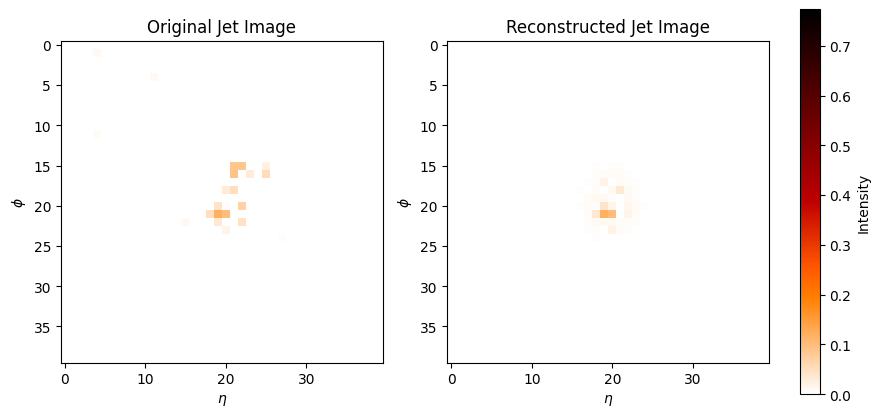

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


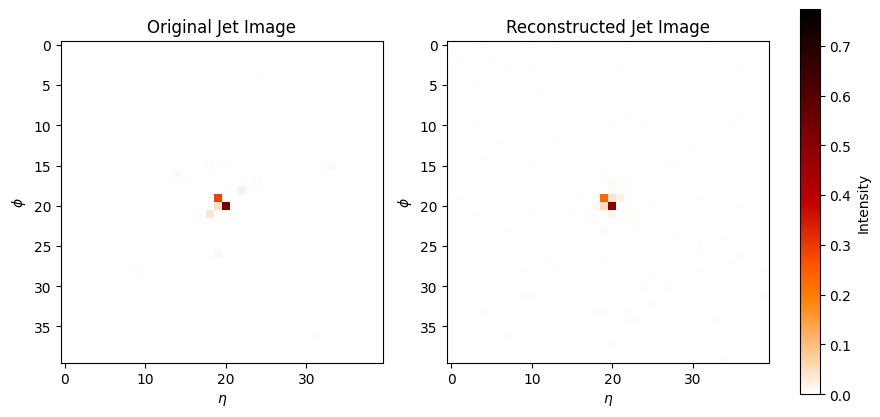

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


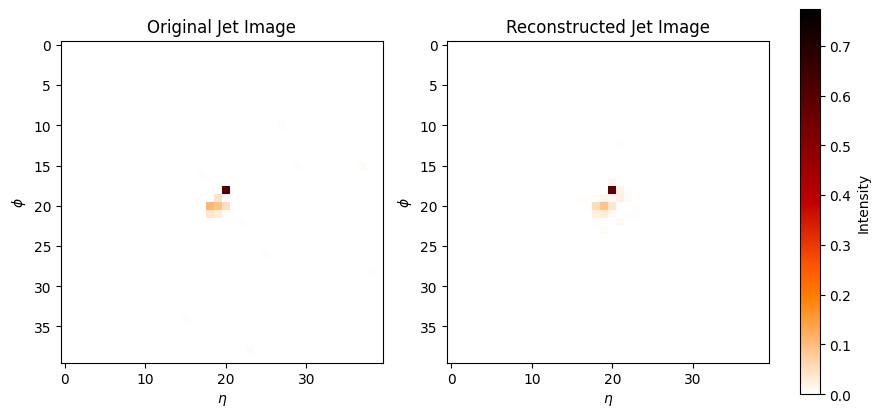

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


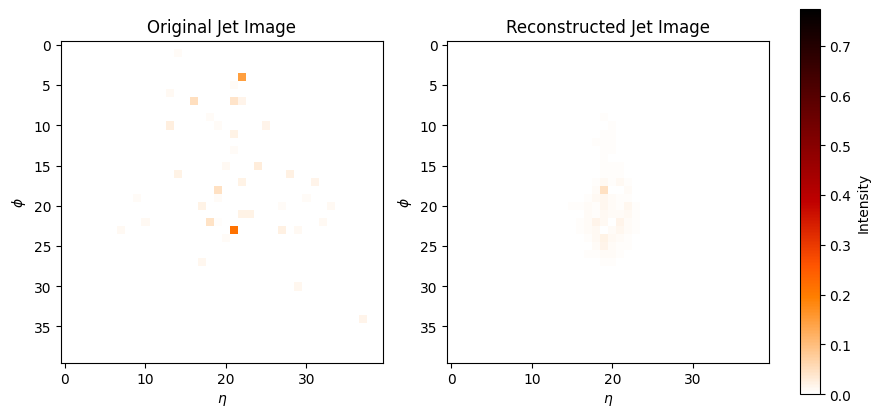

In [114]:
visualize_reconstruction(model=autoencoder, dataloader=qcd_dataloader_train,seed=seed_qcd_train,
                         num_examples=4, device=device, intensity_factor=1)

2. Let's plot a few original qcd validation dataset and reconstructed dataset. (recall that the autoencodermlp model is trained on the QCD dataset)

vmin is: 0 and vmax is 0.8060302734375
shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


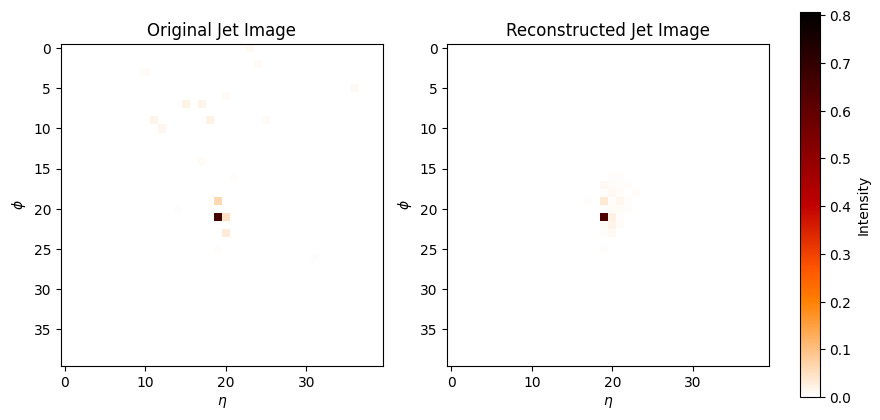

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


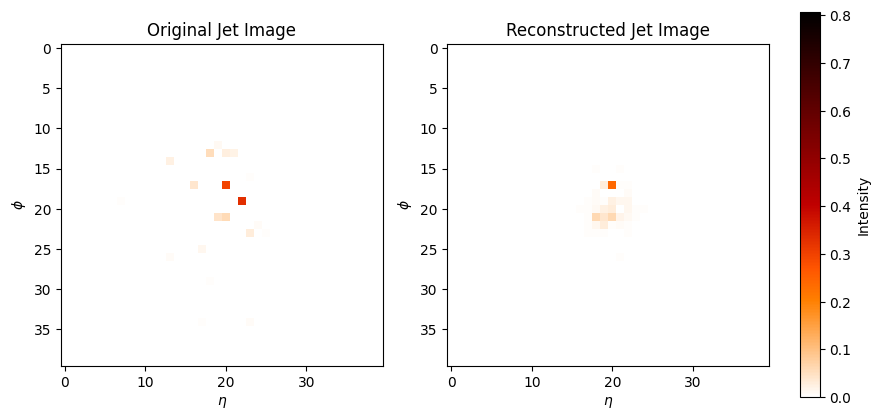

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


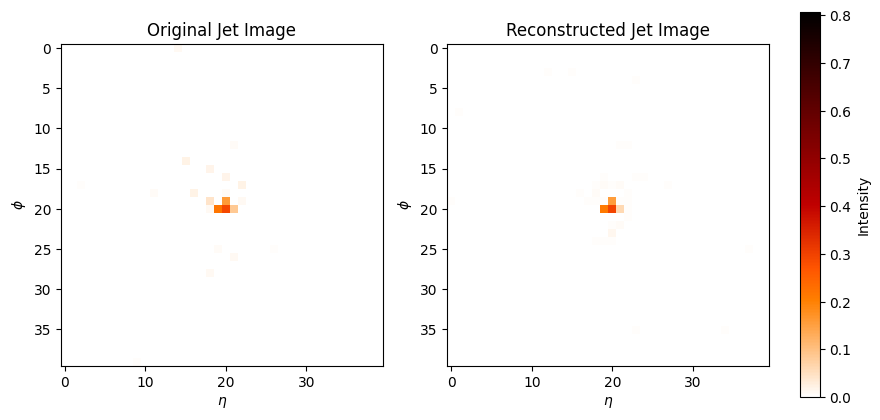

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


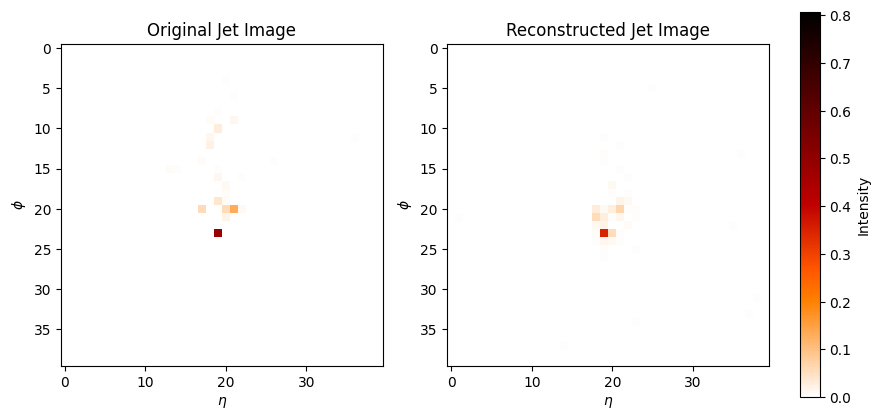

In [115]:
visualize_reconstruction(model=autoencoder, dataloader=qcd_dataloader_val,seed=seed_qcd_val,
                         num_examples=4, device=device)

3. Now let's plot the original top validation dataset and the reconstructed data (recall that the autoencodermlp model is trained on the QCD dataset)

 Case of top jets' reconstruction
vmin is: 0 and vmax is 0.5383932590484619
shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


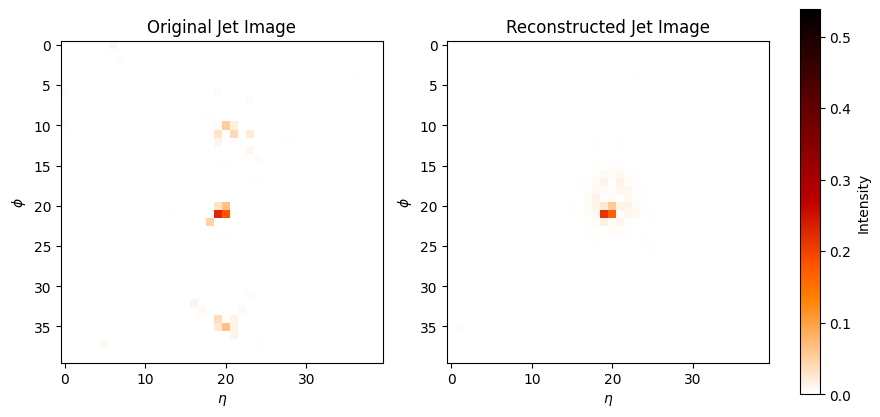

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


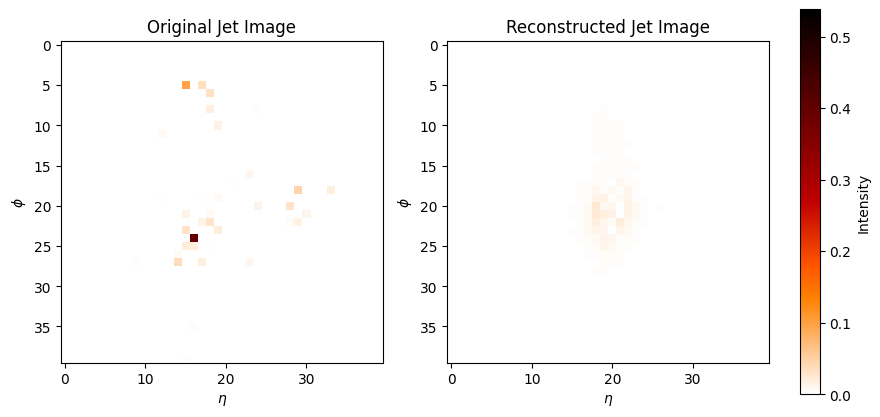

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


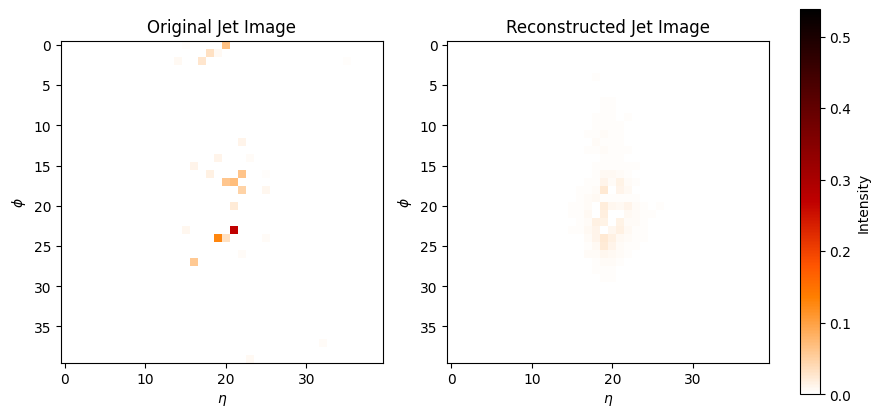

shape of the original image: (40, 40)
shape of the reconstructed image: (40, 40)


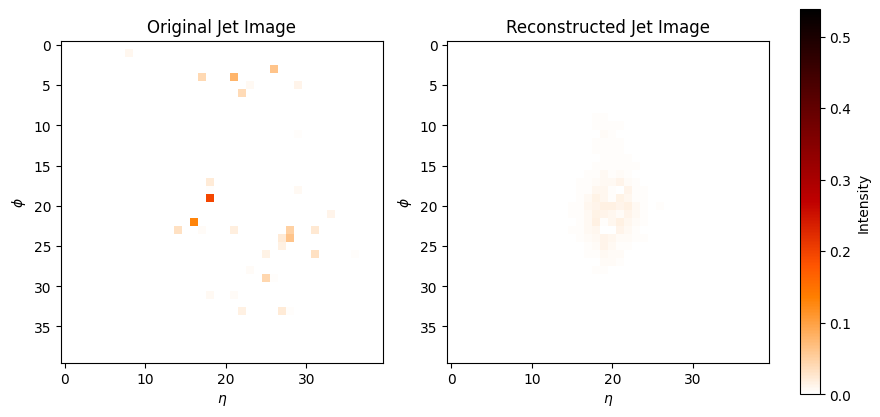

In [116]:
print(" Case of top jets' reconstruction")
visualize_reconstruction(model=autoencoder, dataloader=top_dataloader_val,seed=seed_top_val,
                         num_examples=4, device=device)

### `Comment:` As we can see from three cases above, the quality  of reconstructed for qcd is better than the quality of reconstruction for tops!


The qcd jets are more centered around (20,20) whereas the top jets are way more scattered. Since during training, the autoencoder model (made up of mlps) only saw the qcd dataset (centered around the centre), it is difficult for it to reconstruct the top dataset.

(d) plotting pixel-wise MSE

In [109]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_pixelwise_mse(model, dataloader, seed, num_examples=5, device="cpu", intensity_factor=1):
    model.eval()  # Set the model to evaluation mode

    # Set random seed for PyTorch and NumPy
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Get a few examples from the dataloader
    data_iter = iter(dataloader)
    examples, _ = next(data_iter)
    examples = examples.to(device)

    # Forward pass to obtain reconstructed outputs
    with torch.no_grad():
        reconstructed_outputs = model(examples.view(examples.size(0), -1).float())

    # Convert tensors to NumPy arrays
    examples_np = examples.cpu().numpy()
    reconstructed_outputs_np = reconstructed_outputs.cpu().numpy()

    # Normalize pixel values to a common range
    vmin = 0
    vmax = intensity_factor * max(np.max(examples_np), np.max(reconstructed_outputs_np))
    print(f"vmin is: {vmin} and vmax is {vmax}")

    # Visualize the original, reconstructed images, and pixel-wise MSE heatmap
    for i in range(num_examples):
        original_image = examples_np[i].reshape(examples.size(2), examples.size(3))
        reconstructed_image = reconstructed_outputs_np[i].reshape(examples.size(2), examples.size(3))

        # Calculate pixel-wise MSE
        pixelwise_mse = np.square(original_image - reconstructed_image)

        # Plot side-by-side with shared colorbar for original and reconstructed images
        # and a separate colorbar for the pixel-wise MSE heatmap
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        im1 = axs[0].imshow(intensity_factor * original_image, cmap="gist_heat_r", vmin=vmin, vmax=vmax)
        axs[0].set_title("Original Jet Image")
        axs[0].set_xlabel("$\eta$")
        axs[0].set_ylabel("$\phi$")
        axs[0].grid(True, color='black', linestyle='-', linewidth=0.5)

        im2 = axs[1].imshow(intensity_factor * reconstructed_image, cmap="gist_heat_r", vmin=vmin, vmax=vmax)
        axs[1].set_title("Reconstructed Jet Image")
        axs[1].set_xlabel("$\eta$")
        axs[1].set_ylabel("$\phi$")
        axs[1].grid(True, color='black', linestyle='-', linewidth=0.5)

        im3 = axs[2].imshow(intensity_factor * pixelwise_mse, cmap="hot", vmin=0, vmax=np.max(pixelwise_mse))
        axs[2].set_title("Pixel-wise MSE Heatmap")
        axs[2].grid(True, color='green', linestyle='-', linewidth=0.5)

        # Create a common colorbar for the original and reconstructed images
        cbar1 = fig.colorbar(im1, ax=axs[:2], orientation='vertical', fraction=0.046, pad=0.04)
        # cbar1.set_label('Intensity')

        # Create a separate colorbar for the pixel-wise MSE heatmap
        cbar2 = fig.colorbar(im3, ax=axs[2], orientation='vertical', fraction=0.046, pad=0.04)
        cbar2.set_label('MSE')


        plt.show()

vmin is: 0 and vmax is 0.8060302734375


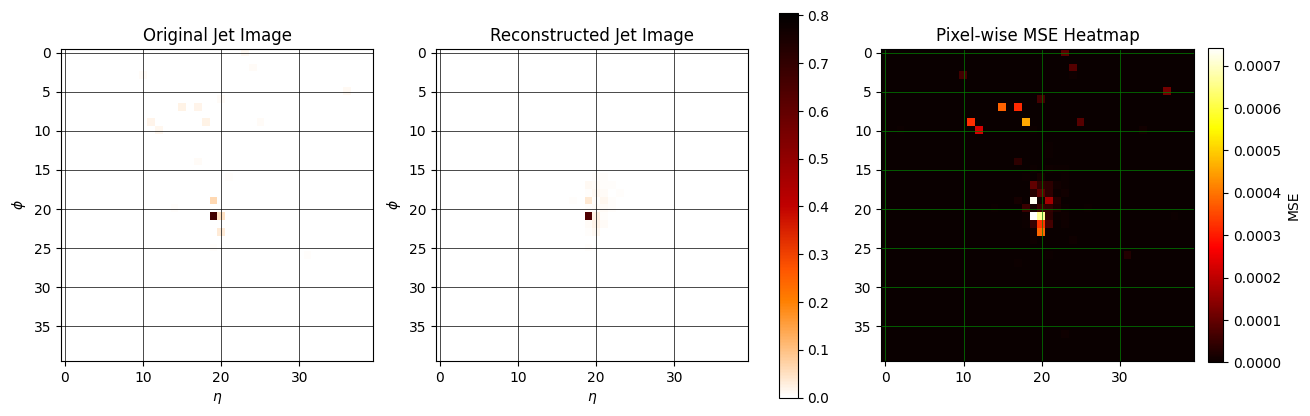

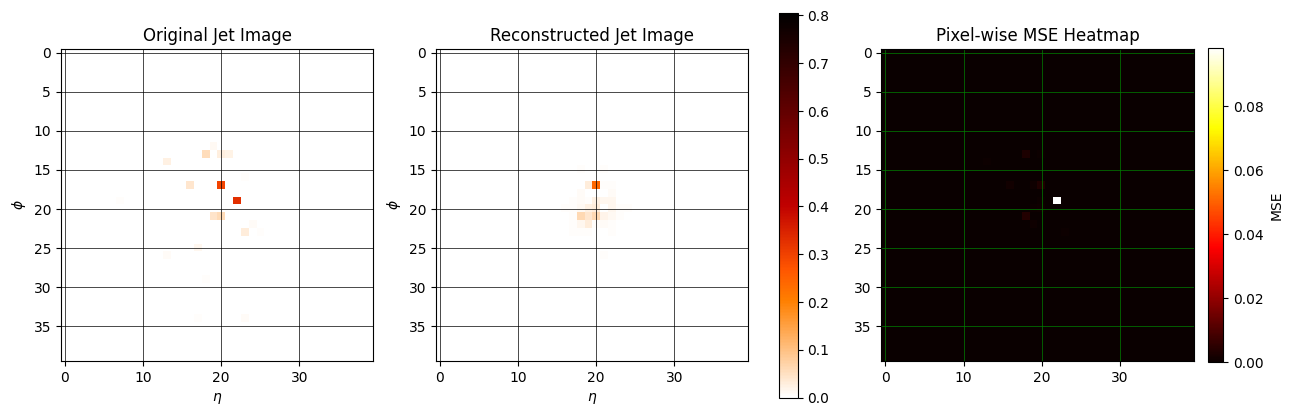

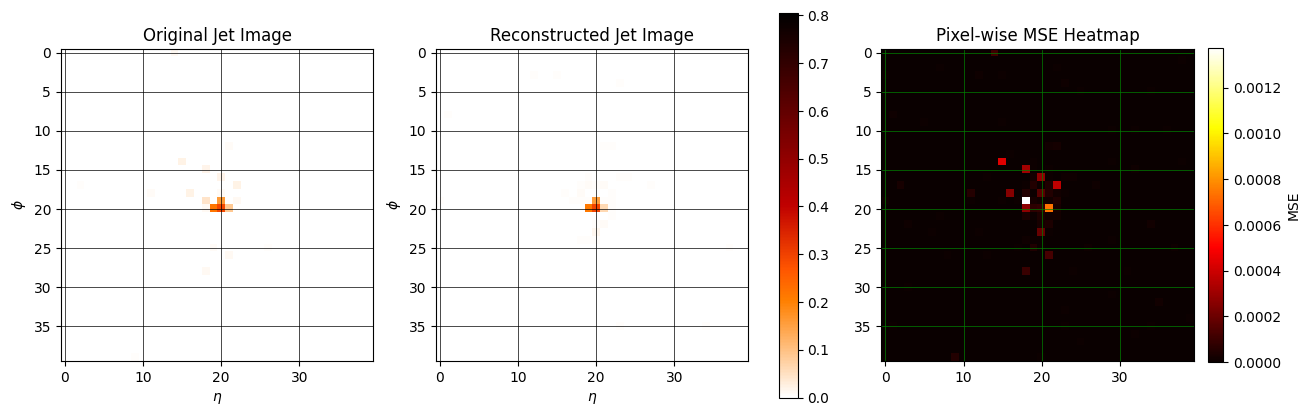

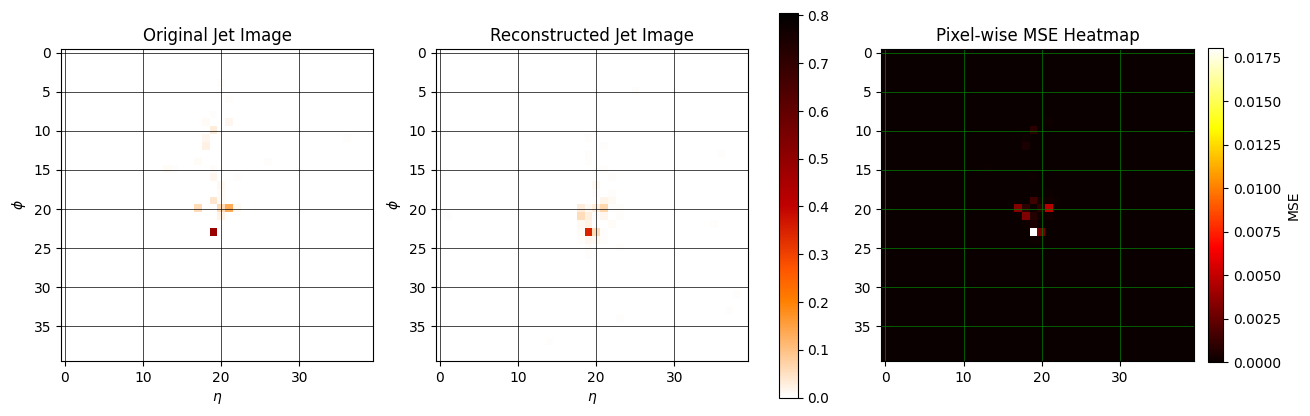

In [119]:
visualize_pixelwise_mse(model=autoencoder, dataloader=qcd_dataloader_val,
                        seed=3, num_examples=4,
                        device=device)


(c)

In [ ]:
# TODO: Visualize original vs reconstructed QCD and top jets

(d)

In [ ]:
# TODO: Visualize pixel-wise MSE, plot ROC

(e)

In [ ]:
# TODO: Repeat everything for CNN

(f)

In [ ]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN